# Analysis in Pandas / Numpy


## The brief

    a. In a data set the elements that exhibit unusual behavior are considered as outliers. One way is to detect outliers is to use the z-score, and call outlier whatever is higher than a threshold (e.g., 3).

i. Detect the **outliers** for each **indicator** for each **region** over the last 10 years.

ii. Then select a **specific region** and get the **outliers** for each indicator for **intervals of 10 years**.

    b. Use **covariance matrices** to explore relationships among all features (i.e. the indicators, e.g. GPD per capita and inflation). This has to be performed for **each region over the last 10 years**.

    c. Build a data set that contains the indicators variables (there should be at least 6 from two different data sets) as columns, and the countries as rows. The cells should correspond to averages over the last 10 years.

i. Perform non-negative matrix decomposition to facilitate a grouping of the **indicator variables**. What are the groupings produced?

    d. **Extra work**: The countries, indicators and years form a 3D matrix, known as Tensor. Perform Tensor decomposition to find interesting patterns.

    e. Draw remarks / conclusions.

# Step 0 - Libraries/Packages and load data

In [16]:
# --- Libraries/Packages ---

import pandas as pd
import pymysql
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from tensorly.decomposition import parafac

# --- CONFIGURATION ---
DB_CONFIG = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'student',  # Update if different
    'database': 'bigdata_project'
}

# --- 1. LOAD DATA FUNCTION ---
def get_data():
    conn = pymysql.connect(**DB_CONFIG)
    # We join all 3 tables to get human-readable names
    query = """
    SELECT 
        c.region, 
        c.country_name, 
        i.indicator_name, 
        v.year, 
        v.value
    FROM indicator_values v
    JOIN countries c ON v.country_id = c.country_id
    JOIN indicators i ON v.indicator_id = i.indicator_id
    WHERE c.region IS NOT NULL
    """
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# Load the data
df = get_data()
print(f"Data Loaded: {len(df)} rows.")
print(df.head())

C:\Users\dkara\AppData\Local\Temp\ipykernel_40916\3814308963.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Data Loaded: 18864 rows.
                                              region          country_name  \
0                                             Africa                Angola   
1                            Europe and Central Asia               Albania   
2                            Europe and Central Asia               Andorra   
3  Middle East, North Africa, Afghanistan & Pakistan  United Arab Emirates   
4                    Latin America and the Caribbean             Argentina   

                          indicator_name  year     value  
0  Current health expenditure (% of GDP)  2008  3.322903  
1  Current health expenditure (% of GDP)  2008  5.509003  
2  Current health expenditure (% of GDP)  2008  5.670664  
3  Current health expenditure (% of GDP)  2008  2.928576  
4  Current health expenditure (% of GDP)  2008  8.182697  


## a. Outliers

### a.1 Detecting outliers for each region.

First, to detect any outliers, we first have to decide on a threshold. Generally, as a golden standard in statistics we assume that in a standard bell curve, 99.7% of all data points fall within 3 standard deviations ($\sigma$) of the average. Anything beyond this (Z-score > 3 or < -3) is extremely rare (0.3% probability) can be safely considered an "anomaly." **Therefore, we will stict to a threshold of 3**

Secondly, to study regions, from a large list of countries (and in some cases, regions and socioeconomic groups), we need to define which countries the regions will included. Since the datasets may also include regions and socioeconimic groups per regions, we will use those as points of reference and comparison in our analysis.The region allocation was facilitated by the existing lists from https://www.worldbank.org/ext/en/where-we-work.

In [17]:
# --- TASK (i): OUTLIERS (LAST 10 YEARS) ---

# 0. Filter for the last 10 years and aggragate data (REGION and SOCIOECONOMIC labeled regions)
# In our case this is not necessary as data was cleaned to only include 2008-2019
df_10years = df[df['year'] >= 2014].copy()
#If region is "REGION" or "SOCIOECONOMIC" we remove those rows
df_outliers = df_10years[~df_10years['region'].isin(['REGION', 'SOCIOECONOMIC'])]



# 1. Calculate Stats per Group (Region + Indicator)
# We use 'transform' to broadcast the mean/std back to every row
df_outliers['mean'] = df_outliers.groupby(['region', 'indicator_name'])['value'].transform('mean')
df_outliers['std']  = df_outliers.groupby(['region', 'indicator_name'])['value'].transform('std')

# 2. Calculate Z-Score
df_outliers['z_score'] = (df_outliers['value'] - df_outliers['mean']) / df_outliers['std']

# 3. Identify Outliers (Threshold > 3)
outliers_10years = df_outliers[abs(df_outliers['z_score']) > 3]

# 4. Display Results
print(f"Found {len(outliers_10years)} outliers in the last 10 years.")

# To be visually clear we show the most extreme ones first
display_cols = ['region', 'country_name', 'indicator_name', 'year', 'value', 'z_score']
print(outliers_10years[display_cols].sort_values('z_score', ascending=False).head(10))

# Viewing regions with most outliers
outlier_counts = outliers_10years['region'].value_counts()
outlier_percent = (outlier_counts / len(outliers_10years)) * 100
print(f"The regions with the most outliers in all indicators are:{outlier_percent}")

Found 139 outliers in the last 10 years.
                                region        country_name  \
2516                            Africa             Lesotho   
12969          Europe and Central Asia  Russian Federation   
12834  Latin America and the Caribbean              Brazil   
15898                           Africa             Nigeria   
15651                           Africa             Nigeria   
1482                            Africa        Sierra Leone   
1700                            Africa        Sierra Leone   
15404                           Africa             Nigeria   
12213  Latin America and the Caribbean              Brazil   
15761  Latin America and the Caribbean              Brazil   

                                          indicator_name  year         value  \
2516               Current health expenditure (% of GDP)  2019  2.196987e+01   
12969  Total greenhouse gas emissions including LULUC...  2019  1.530030e+03   
12834  Total greenhouse gas emission

C:\Users\dkara\AppData\Local\Temp\ipykernel_40916\3498211743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers['mean'] = df_outliers.groupby(['region', 'indicator_name'])['value'].transform('mean')
C:\Users\dkara\AppData\Local\Temp\ipykernel_40916\3498211743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers['std']  = df_outliers.groupby(['region', 'indicator_name'])['value'].transform('std')
C:\Users\dkara\AppData\Local\Temp\ipykernel_40916\3498211743.py:17: SettingWithCopyWarn

In [18]:
# --- TASK (ii): OUTLIERS BY DECADE (SPECIFIC REGION) --- NEED TO GO BACK TO FULL DATASET --- AAAAAAAAAAAAAAAAAAAAAAAAAA

# 1. Select Region
target_region = 'Europe and Central Asia'  # Chose africa for this example since it has diverse data and many countries
df_region = df[df['region'] == target_region].copy()

# 2. Create 10-Year Intervals (Decades)
# This converts 1995 -> 1990, 2012 -> 2010, etc.
df_region['decade'] = (df_region['year'] // 10) * 10

# 3. Calculate Stats per Group (Indicator + Decade)
# "Is this value weird for Europe in the 1990s?"
df_region['mean'] = df_region.groupby(['indicator_name', 'decade'])['value'].transform('mean')
df_region['std']  = df_region.groupby(['indicator_name', 'decade'])['value'].transform('std')

# 4. Calculate Z-Score
df_region['z_score'] = (df_region['value'] - df_region['mean']) / df_region['std']

# 5. Identify Outliers
outliers_interval = df_region[abs(df_region['z_score']) > 3]

# 6. Display Results
print(f"Found {len(outliers_interval)} outliers in {target_region} across all decades.")
display_cols_ii = ['decade', 'country_name', 'indicator_name', 'value', 'z_score']
print(outliers_interval[display_cols_ii].sort_values(['decade', 'indicator_name']).head(15))

Found 73 outliers in Europe and Central Asia across all decades.
       decade        country_name  \
2788     2000          Tajikistan   
2986     2000          Tajikistan   
5161     2000              Serbia   
5371     2000              Serbia   
13207    2000  Russian Federation   
13454    2000  Russian Federation   
16087    2000             Iceland   
16327    2000             Iceland   
10578    2000             Germany   
10785    2000             Germany   
3020     2010          Azerbaijan   
3184     2010          Tajikistan   
3218     2010          Azerbaijan   
3382     2010          Tajikistan   
3580     2010          Tajikistan   

                                          indicator_name         value  \
2788   People using at least basic drinking water ser...  5.746386e+01   
2986   People using at least basic drinking water ser...  5.916570e+01   
5161   People using at least basic drinking water ser...  8.875615e+01   
5371   People using at least basic drinking wa

# b. Covarience Matrices

For this task we will pivot the data so that Indicators become columns (Features) and Countries become rows and loop through each region (e.g., Europe, Asia). Then we will calculate the Covariance (to satisfy the requirement) but Visualize the Correlation (so the heatmap is actually readable).

Data Reshaped Successfully!
Matrix Size: 9 Regions x 8 Indicators

First 3 rows of your Matrix:


indicator_name,Current health expenditure (% of GDP),People using at least basic drinking water services rural (% of rural population),People using at least basic drinking water services urban (% of urban population),People using safely managed sanitation services rural (% of rural population),People using safely managed sanitation services urban (% of urban population),Population total,Renewable energy consumption (% of total final energy consumption),Total greenhouse gas emissions including LULUCF (Mt CO2e)
region,,,,,,,,
Africa,5.247045,50.233499,83.442905,16.262614,22.656248,2.057933e+07,65.014894,51.97923
East Asia and Pacific,4.454492,73.980358,94.523721,35.805456,56.032903,1.057024e+08,21.051190,964.98180
Europe and Central Asia,7.632519,95.603005,98.656549,72.394985,71.953235,1.530701e+07,19.840152,145.73453


--- Covariance Matrix (Hard to read due to different units) ---


indicator_name,Current health expenditure (% of GDP),People using at least basic drinking water services rural (% of rural population),People using at least basic drinking water services urban (% of urban population),People using safely managed sanitation services rural (% of rural population)
indicator_name,,,,
Current health expenditure (% of GDP),8.559895,22.793716,6.422720,44.280609
People using at least basic drinking water services rural (% of rural population),22.793716,212.092668,66.122198,245.490439
People using at least basic drinking water services urban (% of urban population),6.422720,66.122198,22.606485,81.109426
People using safely managed sanitation services rural (% of rural population),44.280609,245.490439,81.109426,434.777546



--- Correlation Matrix (Easy to read: -1 to +1) ---


indicator_name,Current health expenditure (% of GDP),People using at least basic drinking water services rural (% of rural population),People using at least basic drinking water services urban (% of urban population),People using safely managed sanitation services rural (% of rural population),People using safely managed sanitation services urban (% of urban population),Population total,Renewable energy consumption (% of total final energy consumption),Total greenhouse gas emissions including LULUCF (Mt CO2e)
indicator_name,,,,,,,,
Current health expenditure (% of GDP),1.000000,0.534956,0.461709,0.725848,0.546988,-0.139164,-0.455983,0.128253
People using at least basic drinking water services rural (% of rural population),0.534956,1.000000,0.954922,0.808422,0.594369,-0.149513,-0.671070,-0.045017
People using at least basic drinking water services urban (% of urban population),0.461709,0.954922,1.000000,0.818128,0.649368,-0.146372,-0.768538,-0.029922
People using safely managed sanitation services rural (% of rural population),0.725848,0.808422,0.818128,1.000000,0.847833,-0.332140,-0.730180,-0.120057
People using safely managed sanitation services urban (% of urban population),0.546988,0.594369,0.649368,0.847833,1.000000,-0.077179,-0.733301,0.147995
Population total,-0.139164,-0.149513,-0.146372,-0.332140,-0.077179,1.000000,0.171980,0.949499
Renewable energy consumption (% of total final energy consumption),-0.455983,-0.671070,-0.768538,-0.730180,-0.733301,0.171980,1.000000,0.023701
Total greenhouse gas emissions including LULUCF (Mt CO2e),0.128253,-0.045017,-0.029922,-0.120057,0.147995,0.949499,0.023701,1.000000


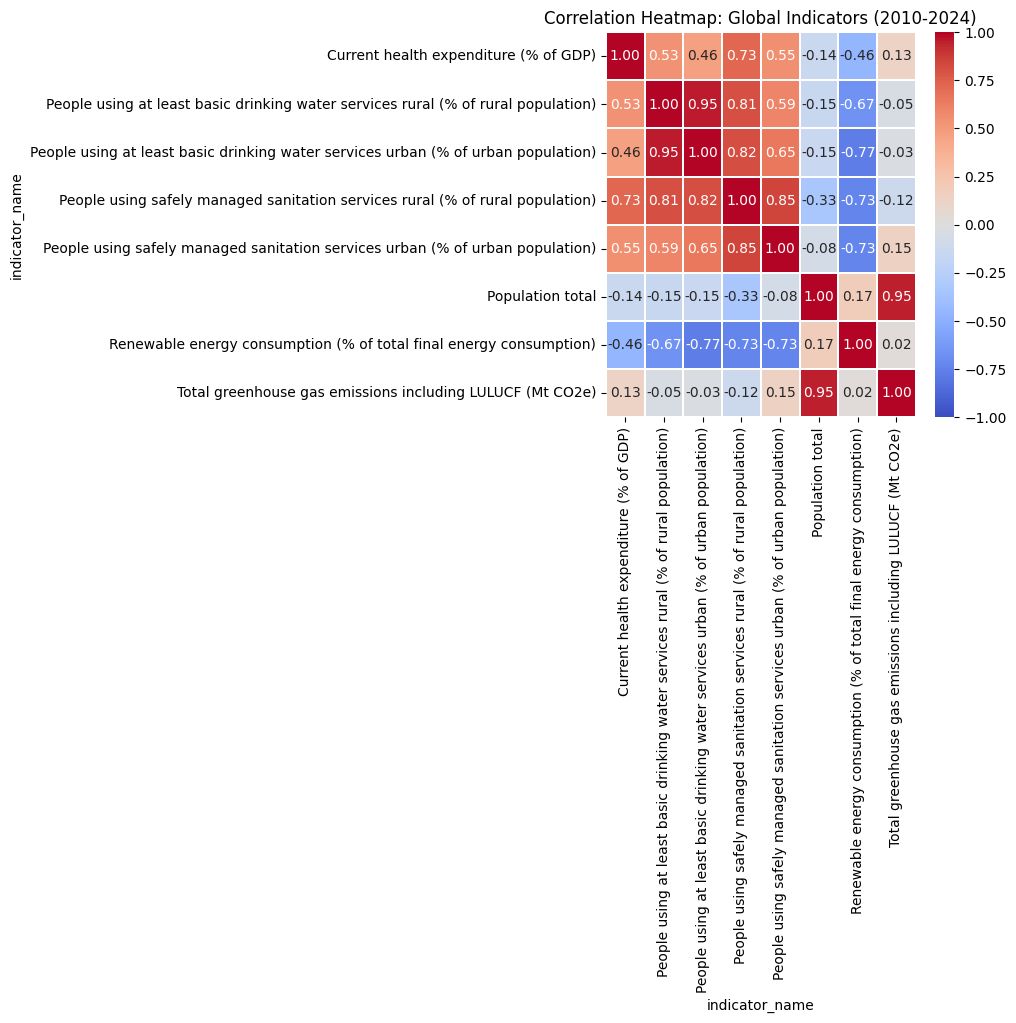

In [ ]:
# --- 1. PIVOT THE DATA ---
# We average the values over the years (2010-2024) to get ONE number per country per indicator.
# Index (Rows) = Country Name
# Columns = Indicator Name
# Values = The actual numbers
df_pivot = df.pivot_table(index='region', columns='indicator_name', values='value', aggfunc='mean') # Averaging over years

print("Data Reshaped Successfully!")
print(f"Matrix Size: {df_pivot.shape[0]} Regions x {df_pivot.shape[1]} Indicators") # Rows x Columns
print("\nFirst 3 rows of your Matrix:") # Display first 3 rows
display(df_pivot.head(3))

# --- 2. CALCULATE MATRICES ---

# A. Covariance Matrix (Required by project instructions)
cov_matrix = df_pivot.cov() # Covariance by default

# B. Correlation Matrix (Best for visualization)
corr_matrix = df_pivot.corr() # Pearson Correlation by default

print("--- Covariance Matrix (Hard to read due to different units) ---")
display(cov_matrix.iloc[:4, :4]) # Show just a tiny corner

print("\n--- Correlation Matrix (Easy to read: -1 to +1) ---")
display(corr_matrix.iloc[:8, :8]) # Show just a tiny corner

# --- 3. VISUALIZE WITH HEATMAP ---
# Set up the matplotlib figure
plt.figure(figsize=(5, 5)) # Make it big enough to read

# Draw the heatmap using the CORRELATION matrix
sns.heatmap(
    corr_matrix, 
    annot=True,       # Write the actual numbers in the boxes
    cmap='coolwarm',  # Red = Positive, Blue = Negative
    fmt=".2f",        # Show 2 decimal places (e.g., 0.85)
    linewidths=0.2,   # Add white lines between boxes for clarity
    vmin=-1, vmax=1   # Lock the scale between -1 and 1
)

plt.title("Correlation Heatmap: Global Indicators (2010-2024)")
plt.show()

## PENDING COMMENTS AND GROUPINGS

 
### Infrastructure Block

**Variables**: Water Services (Rural/Urban) and Sanitation (Rural/Urban)

**Correlation**: 0.80 to 0.95 (Very High)

**Conclusion**: These indicators move together almost perfectly. If a country has good rural water access, it almost certainly has good urban water access and sanitation. This confirms why NMF grouped them together—they represent a single underlying factor: Development Level.


### Scale Effect

**Variables**: Population Total and GHG Emissions

**Correlation**: 0.95 (Extremely High)

**Conclusion**: This is a massive finding. It shows that 95% of the variation in GHG emissions in your dataset is explained simply by how many people a country has.

Report Note: This implies that "being a big country" is the primary driver of total emissions, rather than "being an inefficient country."


### Renewable Energy Paradox??????????? MUST CHECK IN BC AI

**Variables**: Renewable Energy vs. Water/Sanitation??????????

**Correlation**: -0.67 to -0.76 (Strong Negative)

**Conclusion**: This is the most counter-intuitive and interesting finding for your report.

**What it means**: As countries become more developed (better water/sanitation), their share of renewable energy goes DOWN.

Why? In developing nations, "Renewable Energy" often means burning wood/biomass for survival. In developed nations, energy is industrial (Fossil Fuels/Nuclear).

Key Takeaway: High "Renewable Consumption" in this dataset likely indicates underdevelopment, not high-tech green energy.


### Health Expenditure

**Correlation**: Moderate Positive (~0.55) with Sanitation/Water.

**Conclusion**: Wealthier nations (better infrastructure) spend more on health, but the link isn't as strong as the link between water and sanitation.

# c. Variables and non-negative matrix decomposition
    
"Build a data set that contains the indicators variables (there should be at least 6 from two different data sets) as columns, and the countries as rows. The cells should correspond to averages over the last 10 years. Perform non-negative matrix decomposition to facilitate a grouping of the **indicator variables**. What are the groupings produced?"

In [ ]:
# Checkpoint: 
# Check data completeness in the database 

DB_CONFIG = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'student',
    'database': 'bigdata_project'
}

conn = pymysql.connect(**DB_CONFIG)

# This query checks "Total Rows" vs "Rows with valid Year" vs "Rows with valid Region"
query_debug = """
SELECT 
    i.indicator_name, 
    COUNT(*) as total_rows_in_db,
    SUM(CASE WHEN v.year >= 2008 THEN 1 ELSE 0 END) as rows_with_valid_year,
    SUM(CASE WHEN c.region IS NOT NULL THEN 1 ELSE 0 END) as rows_with_valid_region,
    SUM(CASE WHEN v.year >= 2008 AND c.region IS NOT NULL THEN 1 ELSE 0 END) as rows_passing_both
FROM indicator_values v
JOIN countries c ON v.country_id = c.country_id
JOIN indicators i ON v.indicator_id = i.indicator_id
GROUP BY i.indicator_name
"""

df_debug = pd.read_sql(query_debug, conn)
conn.close()

print(df_debug)

                                      indicator_name  total_rows_in_db  \
0              Current health expenditure (% of GDP)              2820   
1  People using at least basic drinking water ser...              2568   
2  People using at least basic drinking water ser...              2712   
3  People using safely managed sanitation service...              1404   
4  People using safely managed sanitation service...              1848   
5  Total greenhouse gas emissions including LULUC...              2688   
6                                   Population total              3180   
7  Renewable energy consumption (% of total final...              3096   

   rows_with_valid_year  rows_with_valid_region  rows_passing_both  
0                2820.0                  2616.0             2616.0  
1                2568.0                  2376.0             2376.0  
2                2712.0                  2520.0             2520.0  
3                1404.0                  1308.0          

C:\Users\dkara\AppData\Local\Temp\ipykernel_40916\868205848.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_debug = pd.read_sql(query_debug, conn)


C:\Users\dkara\AppData\Local\Temp\ipykernel_40916\3527332629.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)


Dataset Built: 247 Countries x 8 Indicators
⚠️ Shifted 'Total greenhouse gas emissions including LULUCF (Mt CO2e)' by 169.15 to make it non-negative.


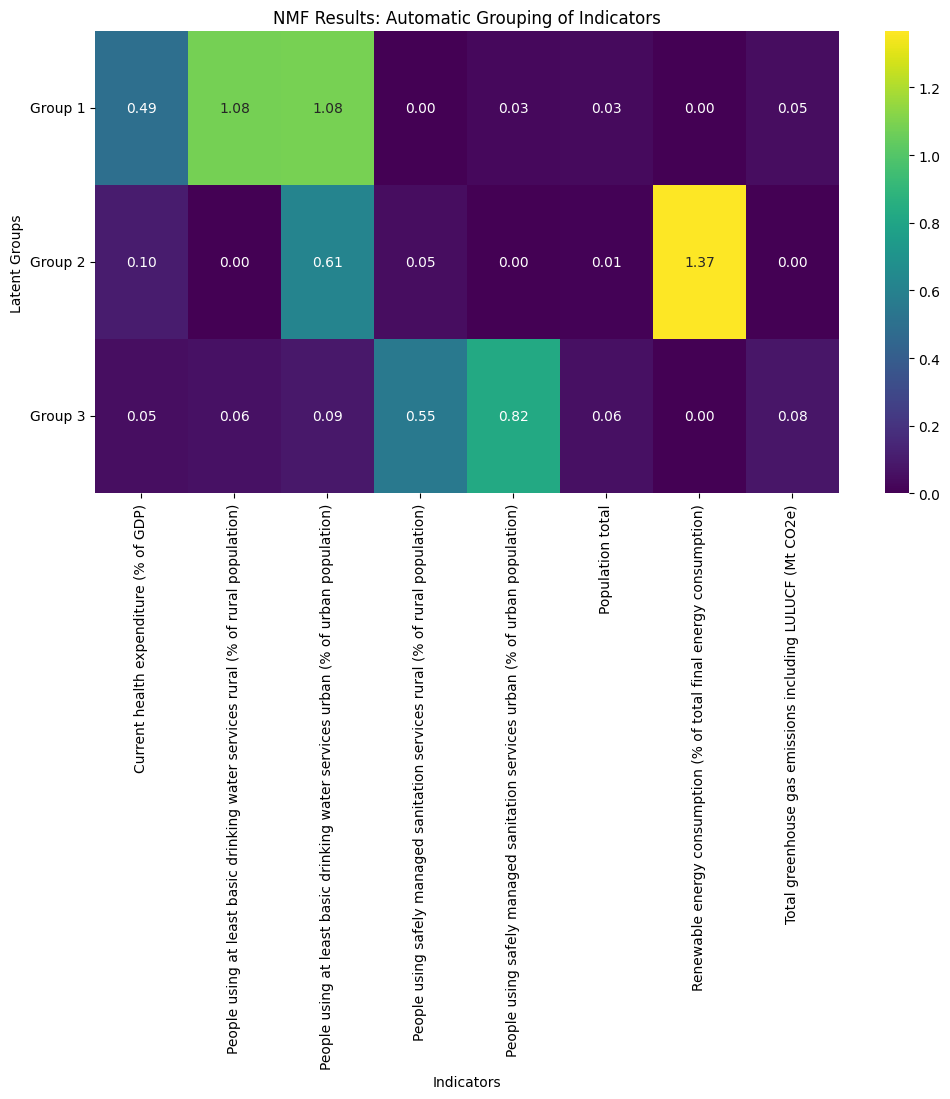


--- Interpretation of Groupings ---

Group 1 is defined by:
  - People using at least basic drinking water services urban (% of urban population) (Score: 1.08)
  - People using at least basic drinking water services rural (% of rural population) (Score: 1.08)
  - Current health expenditure (% of GDP) (Score: 0.49)

Group 2 is defined by:
  - Renewable energy consumption (% of total final energy consumption) (Score: 1.37)
  - People using at least basic drinking water services urban (% of urban population) (Score: 0.61)
  - Current health expenditure (% of GDP) (Score: 0.10)

Group 3 is defined by:
  - People using safely managed sanitation services urban (% of urban population) (Score: 0.82)
  - People using safely managed sanitation services rural (% of rural population) (Score: 0.55)
  - People using at least basic drinking water services urban (% of urban population) (Score: 0.09)


In [ ]:
# --- TASK (iii): NMF FOR AUTOMATIC GROUPING OF INDICATORS ------
# --- 1. CONFIGURATION ------
DB_CONFIG = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'student',
    'database': 'bigdata_project'
}

# --- 2. GET DATA (Last 10 Years Average) ---
conn = pymysql.connect(**DB_CONFIG)

# We fetch raw values for the last 10 years for all available years. Will come back to change later if needed!
query = """
SELECT c.country_name, i.indicator_name, v.value
FROM indicator_values v
JOIN countries c ON v.country_id = c.country_id
JOIN indicators i ON v.indicator_id = i.indicator_id
WHERE v.year >= 2008 
  AND c.region IS NOT NULL
"""
df_raw = pd.read_sql(query, conn) # Load raw data
conn.close() # Close connection

# Pivot: Rows=Countries, Cols=Indicators, Values=Average
# This automatically computes the average over the 10 years for each country
df_pivot = df_raw.pivot_table(index='country_name', columns='indicator_name', values='value', aggfunc='mean') # Average over years

print(f"Dataset Built: {df_pivot.shape[0]} Countries x {df_pivot.shape[1]} Indicators") # Rows x Columns

# --- 3. PRE-PROCESSING (CRITICAL FOR NMF) ---
# A. Fill Missing Values (NMF cannot handle NaNs)
df_clean = df_pivot.fillna(0) #SOS!

# B. Handle Negative Values (NMF cannot handle Negatives)
# GHG Emissions can be negative (carbon sinks). We shift the data up so the minimum is 0.
for col in df_clean.columns: # Check each indicator
    min_val = df_clean[col].min() # Get minimum value
    if min_val < 0: # Shift if negative
        print(f"⚠️ Shifted '{col}' by {abs(min_val):.2f} to make it non-negative.") # Log the shift
        df_clean[col] += abs(min_val) # Shift up

# C. Normalize (Scale to 0-1)
# Population is in Billions, Health is in %. We scale them so Pop doesn't dominate.
scaler = MinMaxScaler() # Scale each feature to [0, 1]
df_scaled = scaler.fit_transform(df_clean) # Apply scaling
df_normalized = pd.DataFrame(df_scaled, columns=df_clean.columns, index=df_clean.index) # Back to DataFrame

# --- 4. PERFORM NMF ---
# We look for 3 hidden "components" (Groups)
num_components = 3 # You can adjust this number
model = NMF(n_components=num_components, init='random', random_state=42, max_iter=1000) # Initialize NMF model

W = model.fit_transform(df_normalized)  # Country Features
H = model.components_                   # Indicator Features (The Groupings)

# --- 5. VISUALIZE THE GROUPINGS ---
group_names = [f'Group {i+1}' for i in range(num_components)] # Naming the groups
components_df = pd.DataFrame(H, columns=df_normalized.columns, index=group_names) # DataFrame for easy plotting

plt.figure(figsize=(12, 6))
# Plot heatmap
sns.heatmap(components_df, cmap='viridis', annot=True, fmt=".2f")
plt.title("NMF Results: Automatic Grouping of Indicators")
plt.xlabel("Indicators")
plt.ylabel("Latent Groups")
plt.yticks(rotation=0)
plt.show()

# --- 6. PRINT TOP INDICATORS PER GROUP ---
print("\n--- Interpretation of Groupings ---")
for i, group in enumerate(group_names):
    top_indicators = components_df.loc[group].sort_values(ascending=False).head(3)
    print(f"\n{group} is defined by:")
    for ind, score in top_indicators.items():
        print(f"  - {ind} (Score: {score:.2f})")